# Tutorial: Modern Pandas - Indexes (Part 3)
This tutorial can be accessed [here](http://tomaugspurger.github.io/modern-3-indexes).

Indexes can be a difficult concept to grasp at first. I suspect this is partly because they're somewhat peculiar to pandas. These aren't like the indexes put on relational database tables for performance optimizations. Rather, they're more like the row_labels of an R DataFrame, but much more capable.

Indexes offer:
* metadata container
* easy label-based row selection
* easy label-based alignment in operations
* label-based concatenation

To demonstrate these, we'll first fetch some more data. This will be weather data from sensors at a bunch of airports across the US. See [here](https://github.com/akrherz/iem/blob/master/scripts/asos/iem_scraper_example.py) for the example scraper I based this off of.

## Libraries

In [2]:
import json
import glob
import datetime
from io import StringIO
from tqdm import tqdm

import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Configurations

In [3]:
%matplotlib inline

sns.set_style('ticks')

# States are broken into networks. The networks have a list of ids, each representing a station.
# We will take that list of ids and pass them as query parameters to the URL we built up ealier.
states = """AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME
 MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT
 WA WI WV WY""".split()

# IEM has Iowa AWOS sites in its own labeled network
networks = ['AWOS'] + ['{}_ASOS'.format(state) for state in states]

## Helper Methods

In [4]:
def get_weather(stations, start=pd.Timestamp('2017-01-01'),
                end=pd.Timestamp('2017-01-31')):
    '''
    Fetch weather data from MESONet between ``start`` and ``stop``.
    '''
    url = ("http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"
           "&data=tmpf&data=relh&data=sped&data=mslp&data=p01i&data=v"
           "sby&data=gust_mph&data=skyc1&data=skyc2&data=skyc3"
           "&tz=Etc/UTC&format=comma&latlon=no"
           "&{start:year1=%Y&month1=%m&day1=%d}"
           "&{end:year2=%Y&month2=%m&day2=%d}&{stations}")
    stations = "&".join("station=%s" % s for s in stations)
    weather = (pd.read_csv(url.format(start=start, end=end, stations=stations),
                           comment="#")
                 .rename(columns={"valid": "date"})
                 .rename(columns=str.strip)
                 .assign(date=lambda df: pd.to_datetime(df['date']))
                 .set_index(["station", "date"])
                 .sort_index())
    float_cols = ['tmpf', 'relh', 'sped', 'mslp', 'p01i', 'vsby', "gust_mph"]
    weather[float_cols] = weather[float_cols].apply(pd.to_numeric, errors="corce")
    
    return weather

def get_ids(network):
    url = "http://mesonet.agron.iastate.edu/geojson/network.php?network={}"
    r = requests.get(url.format(network))
    md = pd.io.json.json_normalize(r.json()['features'])
    md['network'] = network
    return md

There isn't too much in get_weather worth mentioning, just grabbing some CSV files from various URLs. They put metadata in the "CSV"s at the top of the file as lines prefixed by a #. Pandas will ignore these with the comment='#' parameter.

I do want to talk briefly about the gem of a method that is `json_normalize`. The weather API returns some slightly-nested data.

In [5]:
url = "http://mesonet.agron.iastate.edu/geojson/network.php?network={}"
r = requests.get(url.format("AWOS"))
js = r.json()

js['features'][:2]

[{'geometry': {'coordinates': [-94.2724, 43.0796], 'type': 'Point'},
  'id': 'AXA',
  'properties': {'climate_site': 'IA0133',
   'country': 'US',
   'county': 'Kossuth',
   'elevation': 368.8,
   'ncdc81': 'USC00130133',
   'sid': 'AXA',
   'sname': 'ALGONA',
   'state': 'IA',
   'tzname': 'America/Chicago',
   'ugc_county': 'IAC109',
   'ugc_zone': 'IAZ005',
   'wfo': 'DMX'},
  'type': 'Feature'},
 {'geometry': {'coordinates': [-93.5695, 41.6878], 'type': 'Point'},
  'id': 'IKV',
  'properties': {'climate_site': 'IA0241',
   'country': 'US',
   'county': 'Polk',
   'elevation': 270.7,
   'ncdc81': 'USC00130241',
   'sid': 'IKV',
   'sname': 'ANKENY',
   'state': 'IA',
   'tzname': 'America/Chicago',
   'ugc_county': 'IAC153',
   'ugc_zone': 'IAZ060',
   'wfo': 'DMX'},
  'type': 'Feature'}]

If we just pass that list off to the DataFrame constructor, we get this.

In [6]:
pd.DataFrame(js['features']).head()

,geometry,id,properties,type
0,"{'type': 'Point', 'coordinates': [-94.2724, 43...",AXA,"{'ugc_county': 'IAC109', 'sname': 'ALGONA', 'u...",Feature
1,"{'type': 'Point', 'coordinates': [-93.5695, 41...",IKV,"{'ugc_county': 'IAC153', 'sname': 'ANKENY', 'u...",Feature
2,"{'type': 'Point', 'coordinates': [-95.0465, 41...",AIO,"{'ugc_county': 'IAC029', 'sname': 'ATLANTIC', ...",Feature
3,"{'type': 'Point', 'coordinates': [-94.9204, 41...",ADU,"{'ugc_county': 'IAC009', 'sname': 'AUDUBON', '...",Feature
4,"{'type': 'Point', 'coordinates': [-93.8486, 42...",BNW,"{'ugc_county': 'IAC015', 'sname': 'BOONE MUNI'...",Feature


In general, DataFrames don't handle nested data that well. It's often better to normalize it somehow. In this case, we can "lift" the nested items (`geometry.coordinates`, `properties.sid`, and `properties.sname`) up to the top level.

In [7]:
pd.io.json.json_normalize(js['features']).head(10)

,geometry.coordinates,geometry.type,id,properties.climate_site,properties.country,properties.county,properties.elevation,properties.ncdc81,properties.sid,properties.sname,properties.state,properties.tzname,properties.ugc_county,properties.ugc_zone,properties.wfo,type
0,"[-94.2724, 43.0796]",Point,AXA,IA0133,US,Kossuth,368.8,USC00130133,AXA,ALGONA,IA,America/Chicago,IAC109,IAZ005,DMX,Feature
1,"[-93.5695, 41.6878]",Point,IKV,IA0241,US,Polk,270.7,USC00130241,IKV,ANKENY,IA,America/Chicago,IAC153,IAZ060,DMX,Feature
2,"[-95.0465, 41.4059]",Point,AIO,IA0364,US,Cass,351.7,USC00130364,AIO,ATLANTIC,IA,America/Chicago,IAC029,IAZ070,DMX,Feature
3,"[-94.9204, 41.6994]",Point,ADU,IA0385,US,Audubon,399.3,USC00130385,ADU,AUDUBON,IA,America/Chicago,IAC009,IAZ057,DMX,Feature
4,"[-93.8486, 42.0486]",Point,BNW,IA0807,US,Boone,349.3,USC00130807,BNW,BOONE MUNI,IA,America/Chicago,IAC015,IAZ047,DMX,Feature
5,"[-94.7889, 42.0444]",Point,CIN,IA1233,US,Carroll,365.2,USC00131233,CIN,CARROLL,IA,America/Chicago,IAC027,IAZ045,DMX,Feature
6,"[-92.8983, 40.6832]",Point,TVK,IA1354,US,Appanoose,313.0,USC00131354,TVK,Centerville,IA,America/Chicago,IAC007,IAZ096,DMX,Feature
7,"[-93.3608, 41.0184]",Point,CNC,IA1394,US,Lucas,319.1,USC00131394,CNC,CHARITON,IA,America/Chicago,IAC117,IAZ084,DMX,Feature
8,"[-92.6132, 43.073]",Point,CCY,IA1402,US,Floyd,340.2,USC00131402,CCY,CHARLES CITY,IA,America/Chicago,IAC067,IAZ018,ARX,Feature
9,"[-95.5538, 42.7304]",Point,CKP,IA1442,US,Cherokee,373.7,USC00131442,CKP,Cherokee,IA,America/Chicago,IAC035,IAZ301,FSD,Feature


Sure, it's not that difficult to write a quick for loop or list comprehension to extract those, but that gets tedious. If we were using the latitude and longitude data, we would want to split the `geometry.coordinates` column into two. But we aren't so we won't.

Going back to the task, we get the airport IDs for every network (state) with get_ids. Then we pass those IDs into get_weather to fetch the actual weather data.

In [8]:
import os

ids = pd.concat([get_ids(network) for network in networks], ignore_index=True)
gr = ids.groupby('network')

store = 'data/weather.h5'

if not os.path.exists(store):
    os.makedirs("data/weather", exist_ok=True)

    for k, v in tqdm(gr):
        weather = get_weather(v['id'])
        weather.to_csv("data/weather/{}.csv".format(k))

    weather = pd.concat([
        pd.read_csv(f, parse_dates=['date'], index_col=['station', 'date'])
        for f in glob.glob('data/weather/*.csv')
    ]).sort_index()

    weather.to_hdf("data/weather.h5", "weather")
else:
    weather = pd.read_hdf("data/weather.h5", "weather")

In [9]:
weather.head()

tmpf   relh  sped  mslp  p01i  vsby  gust_mph  \
station date                                                                 
04V     2017-01-01 00:10:00  23.0  73.51   0.0   NaN   0.0  10.0       NaN   
        2017-01-01 00:30:00  23.0  73.51   5.8   NaN   0.0  10.0       NaN   
        2017-01-01 00:50:00  21.2  79.31   4.6   NaN   0.0  10.0       NaN   
        2017-01-01 01:10:00  21.2  73.32   3.5   NaN   0.0  10.0       NaN   
        2017-01-01 01:30:00  19.4  79.16   3.5   NaN   0.0  10.0       NaN   

                            skyc1 skyc2 skyc3  
station date                                   
04V     2017-01-01 00:10:00   OVC     M     M  
        2017-01-01 00:30:00   BKN     M     M  
        2017-01-01 00:50:00   SCT     M     M  
        2017-01-01 01:10:00   CLR     M     M  
        2017-01-01 01:30:00   SCT     M     M

OK, that was a bit of work. Here's a plot to reward ourselves.

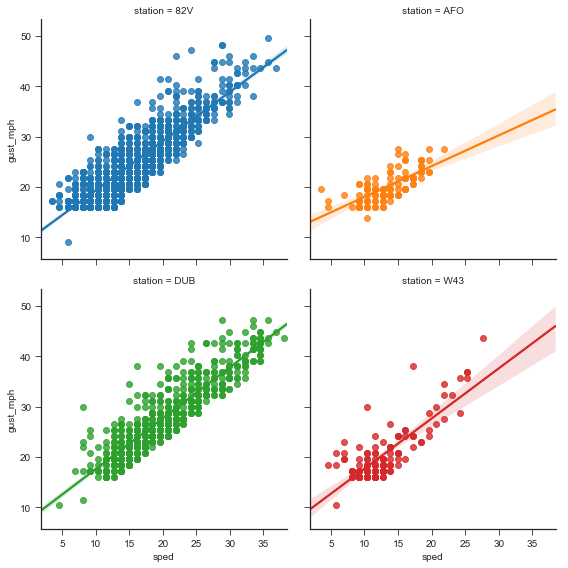

In [10]:
airports = ['W43', 'AFO', '82V', 'DUB']

g = sns.FacetGrid(weather.loc[airports].reset_index(),
                  col='station', hue='station', col_wrap=2, size=4)
g.map(sns.regplot, 'sped', 'gust_mph')

## Set Operations
Indexes are set-like (technically multisets, since you can have duplicates), so they support most python set operations. Since indexes are immutable you won't find any of the inplace set operations. One other difference is that since Indexes are also array-like, you can't use some infix operators like - for difference.

If you have a numeric index it is unclear whether you intend to perform math operations or set operations. You can use & for intersection, | for union, and ^ for symmetric difference though, since there's no ambiguity.

For example, lets find the set of airports that we have both `weather` and `flight` information on. Since `weather` had a `MultiIndex` of `airport`, `datetime`, we'll use the levels attribute to get at the airport data, separate from the date data.

In [11]:
# Bring in the flights data

flights = pd.read_hdf('data/flights.h5', 'flights')

weather_locs = weather.index.levels[0]
# The `categories` attribute of a Categorical is an Index
origin_locs = flights.origin.cat.categories
dest_locs = flights.dest.cat.categories

airports = weather_locs & origin_locs & dest_locs
airports

Index(['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACT', 'ACV', 'ACY', 'AEX', 'AGS',
       ...
       'TUL', 'TUS', 'TVC', 'TWF', 'TXK', 'TYR', 'TYS', 'VLD', 'VPS', 'XNA'],
      dtype='object', length=265)

In [12]:
print("Weather, no flights:\n\t", weather_locs.difference(origin_locs | dest_locs), end='\n\n')

print("Flights, no weather:\n\t", (origin_locs | dest_locs).difference(weather_locs), end='\n\n')

print("Dropped Stations:\n\t", (origin_locs | dest_locs) ^ weather_locs)

Weather, no flights:
	 Index(['04V', '04W', '05U', '06D', '08D', '0A9', '0CO', '0E0', '0F2', '0J4',
       ...
       'Y50', 'Y51', 'Y63', 'Y70', 'YIP', 'YKM', 'YKN', 'YNG', 'ZPH', 'ZZV'],
      dtype='object', length=2069)

Flights, no weather:
	 Index(['ADK', 'ADQ', 'ANC', 'BET', 'BQN', 'BRW', 'CDV', 'FAI', 'FCA', 'GUM',
       'HNL', 'ITO', 'JNU', 'KOA', 'KTN', 'LIH', 'MQT', 'OGG', 'OME', 'OTZ',
       'PPG', 'PSE', 'PSG', 'SCC', 'SCE', 'SIT', 'SJU', 'STT', 'STX', 'WRG',
       'YAK', 'YUM'],
      dtype='object')

Dropped Stations:
	 Index(['04V', '04W', '05U', '06D', '08D', '0A9', '0CO', '0E0', '0F2', '0J4',
       ...
       'Y63', 'Y70', 'YAK', 'YIP', 'YKM', 'YKN', 'YNG', 'YUM', 'ZPH', 'ZZV'],
      dtype='object', length=2101)


### Flavors

Pandas has many subclasses of the regular Index, each tailored to a specific kind of data. Most of the time these will be created for you automatically, so you don't have to worry about which one to choose.

1. `Index`
2. `Int64Index`
3. `RangeIndex: Memory-saving special case of Int64Index`
4. `FloatIndex`
5. `DatetimeIndex: Datetime64[ns] precision data`
6. `PeriodIndex: Regularly-spaced, arbitrary precision datetime data.`
7. `TimedeltaIndex`
8. `CategoricalIndex`
9. `MultiIndex`

You will sometimes create a `DatetimeIndex` with `pd.date_range` (`pd.period_range` for `PeriodIndex`). And you'll sometimes make a `MultiIndex` directly too (I'll have an example of this in my post on performace).

Some of these specialized index types are purely optimizations; others use information about the data to provide additional methods. And while you might occasionally work with indexes directly (like the set operations above), most of they time you'll be operating on a Series or DataFrame, which in turn makes use of its Index.


### Row Slicing
We saw in part one that they're great for making row subsetting as easy as column subsetting.

In [13]:
weather.loc['DSM'].head()

,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
date,,,,,,,,,,
2017-01-01 00:05:00,NaN,NaN,0.0,NaN,NaN,10.0,NaN,CLR,M,M
2017-01-01 00:10:00,NaN,NaN,0.0,NaN,NaN,10.0,NaN,CLR,M,M
2017-01-01 00:15:00,NaN,NaN,0.0,NaN,NaN,10.0,NaN,CLR,M,M
2017-01-01 00:20:00,NaN,NaN,0.0,NaN,NaN,10.0,NaN,CLR,M,M
2017-01-01 00:25:00,NaN,NaN,0.0,NaN,NaN,10.0,NaN,CLR,M,M


Without indexes we'd probably resort to boolean masks.

In [14]:
weather2 = weather.reset_index()
weather2[weather2['station'] == 'DSM'].head()

,station,date,tmpf,relh,sped,mslp,p01i,vsby,gust_mph,skyc1,skyc2,skyc3
2747190,DSM,2017-01-01 00:05:00,NaN,NaN,0.0,NaN,NaN,10.0,NaN,CLR,M,M
2747191,DSM,2017-01-01 00:10:00,NaN,NaN,0.0,NaN,NaN,10.0,NaN,CLR,M,M
2747192,DSM,2017-01-01 00:15:00,NaN,NaN,0.0,NaN,NaN,10.0,NaN,CLR,M,M
2747193,DSM,2017-01-01 00:20:00,NaN,NaN,0.0,NaN,NaN,10.0,NaN,CLR,M,M
2747194,DSM,2017-01-01 00:25:00,NaN,NaN,0.0,NaN,NaN,10.0,NaN,CLR,M,M


Slightly less convenient, but still doable.

### Indexes for Easier Arithmetic, Analysis
It's nice to have your metadata (labels on each observation) next to you actual values. But if you store them in an array, they'll get in the way of your operations. Say we wanted to translate the Fahrenheit temperature to Celsius.

In [15]:
# With indecies
temp = weather['tmpf']

c = (temp - 32) * 5 / 9
c.to_frame().head()

tmpf
station date                     
04V     2017-01-01 00:10:00  -5.0
        2017-01-01 00:30:00  -5.0
        2017-01-01 00:50:00  -6.0
        2017-01-01 01:10:00  -6.0
        2017-01-01 01:30:00  -7.0

In [16]:
# without
temp2 = weather.reset_index()[['station', 'date', 'tmpf']]

temp2['tmpf'] = (temp2['tmpf'] - 32) * 5 / 9
temp2.head()

,station,date,tmpf
0,04V,2017-01-01 00:10:00,-5.0
1,04V,2017-01-01 00:30:00,-5.0
2,04V,2017-01-01 00:50:00,-6.0
3,04V,2017-01-01 01:10:00,-6.0
4,04V,2017-01-01 01:30:00,-7.0


Again, not terrible, but not as good. And, what if you had wanted to keep Fahrenheit around as well, instead of overwriting it like we did? Then you'd need to make a copy of everything, including the `station` and `date` columns. We don't have that problem, since indexes are immutable and safely shared between DataFrames / Series.

In [17]:
temp.index is c.index

True

### Indexes for Alignment
I've saved the best for last. Automatic alignment, or reindexing, is fundamental to pandas.

All binary operations (add, multiply, etc.) between Series/DataFrames first align and then proceed.

Let's suppose we have hourly observations on temperature and windspeed. And suppose some of the observations were invalid, and not reported (simulated below by sampling from the full dataset). We'll assume the missing windspeed observations were potentially different from the missing temperature observations.

In [18]:
dsm = weather.loc['DSM']

hourly = dsm.resample('H').mean()

temp = hourly['tmpf'].sample(frac=.5, random_state=1).sort_index()
sped = hourly['sped'].sample(frac=.5, random_state=2).sort_index()

In [19]:
temp.head().to_frame()

,tmpf
date,
2017-01-01 00:00:00,28.9
2017-01-01 02:00:00,24.1
2017-01-01 03:00:00,24.1
2017-01-01 04:00:00,21.9
2017-01-01 05:00:00,24.1


In [20]:
sped.head().to_frame()

,sped
date,
2017-01-01 01:00:00,3.890909
2017-01-01 02:00:00,4.377778
2017-01-01 03:00:00,6.150000
2017-01-01 04:00:00,4.942857
2017-01-01 05:00:00,7.925000


Suppose that the `windspeed` : `temperature` ratio is meaningful. When we go to compute that, pandas will automatically align the two by index label.


In [21]:
(sped / temp).to_frame().head()

,0
date,
2017-01-01 00:00:00,NaN
2017-01-01 01:00:00,NaN
2017-01-01 02:00:00,0.181651
2017-01-01 03:00:00,0.255187
2017-01-01 04:00:00,0.225701


This lets you focus on doing the operation, rather than manually aligning things, ensuring that the arrays are the same length and in the same order. By deault, missing values are inserted where the two don't align. You can use the method version of any binary operation to specify a `fill_value`.

In [22]:
sped.div(temp, fill_value=1).to_frame().head()

,0
date,
2017-01-01 00:00:00,0.034602
2017-01-01 01:00:00,3.890909
2017-01-01 02:00:00,0.181651
2017-01-01 03:00:00,0.255187
2017-01-01 04:00:00,0.225701


And since I couldn't find anywhere else to put it, you can control the axis the operation is aligned along as well.

And since I couldn't find anywhere else to put it, you can control the axis the operation is aligned along as well.


In [24]:
hourly.div(sped, axis='index').head()

,tmpf,relh,sped,mslp,p01i,vsby,gust_mph
date,,,,,,,
2017-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,6.193925,19.088084,1.0,260.710280,0.0,2.570093,NaN
2017-01-01 02:00:00,5.505076,16.965228,1.0,231.829949,0.0,2.284264,NaN
2017-01-01 03:00:00,3.918699,12.076423,1.0,165.121951,0.0,1.626016,NaN
2017-01-01 04:00:00,4.430636,15.713584,1.0,205.549133,0.0,2.023121,NaN


The non row-labeled version of this is messy.

In [26]:
temp2 = temp.reset_index()
sped2 = sped.reset_index()

# Find rows where the operation is defined
common_dates = pd.Index(temp2.date) & sped2.date
pd.concat([
    # concat to not lose date information
    sped2.loc[sped2['date'].isin(common_dates), 'date'],
    (sped2.loc[sped2.date.isin(common_dates), 'sped'] /
     temp2.loc[temp2.date.isin(common_dates), 'tmpf'])],
    axis=1).dropna(how='all').head()

,date,0
1,2017-01-01 02:00:00,0.181651
2,2017-01-01 03:00:00,0.255187
3,2017-01-01 04:00:00,0.225701
4,2017-01-01 05:00:00,0.328838
8,2017-01-01 13:00:00,NaN


And we have a bug in there. Can you spot it? I only grabbed the dates from sped2 in the line `sped2.loc[sped2['date'].isin(common_dates), 'date']`. Really that should be `sped2.loc[sped2.date.isin(common_dates)] | temp2.loc[temp2.date.isin(common_dates)]`. But I think leaving the buggy version states my case even more strongly. The `temp / sped` version where pandas aligns everything is better.

### Merging

There are two ways of merging DataFrames / Series in Pandas:
1. Relational Database style with `pd.merge`;
2. Array style with `pd.concat`

Personally, I think in terms of the `concat` style.  I learned pandas before I ever really used SQL, so it comes more naturally to me I suppose.

#### Concat Version

In [27]:
pd.concat([temp, sped], axis=1).head()

,tmpf,sped
date,,
2017-01-01 00:00:00,28.9,NaN
2017-01-01 01:00:00,NaN,3.890909
2017-01-01 02:00:00,24.1,4.377778
2017-01-01 03:00:00,24.1,6.150000
2017-01-01 04:00:00,21.9,4.942857


The `axis` parameter controls how the data should be stacked, `0` for vertically, `1` for horizontally. The join parameter controls the merge behavior on the shared axis, (the Index for `axis=1`). By default it's like a union of the two indexes, or an outer join.

#### Merge Version
Since we're joining by index here the merge version is quite similar. We'll see an example later of a one-to-many join where the two differ.

In [28]:
pd.merge(temp.to_frame(), sped.to_frame(), left_index=True, right_index=True).head()

,tmpf,sped
date,,
2017-01-01 02:00:00,24.1,4.377778
2017-01-01 03:00:00,24.1,6.150000
2017-01-01 04:00:00,21.9,4.942857
2017-01-01 05:00:00,24.1,7.925000
2017-01-01 13:00:00,19.9,8.083333


In [29]:
pd.merge(temp.to_frame(), sped.to_frame(), left_index=True, right_index=True, how='outer').head()

,tmpf,sped
date,,
2017-01-01 00:00:00,28.9,NaN
2017-01-01 01:00:00,NaN,3.890909
2017-01-01 02:00:00,24.1,4.377778
2017-01-01 03:00:00,24.1,6.150000
2017-01-01 04:00:00,21.9,4.942857


Like I said, I typically prefer `concat` to `merge`. The exception here is one-to-many type joins. Let's walk through one of those, where we join the flight data to the weather data. To focus just on the merge, we'll aggregate hour weather data to be daily, rather than trying to find the closest recorded weather observation to each departure (you could do that, but it's not the focus right now). We'll then join the one (`airport`, `date`) record to the many (`airport`, `date`, `flight`) records.

Quick tangent, to get the weather data to daily frequency, we'll need to resample (more on that in the timeseries section). The resample essentially splits the recorded values into daily buckets and computes the aggregation function on each bucket. The only wrinkle is that we have to resample by station, so we'll use the `pd.TimeGrouper` helper.

In [30]:
idx_cols = ['unique_carrier', 'origin', 'dest', 'tail_num', 'fl_num', 'fl_date']
data_cols = ['crs_dep_time', 'dep_delay', 'crs_arr_time', 'arr_delay',
             'taxi_out', 'taxi_in', 'wheels_off', 'wheels_on']

df = flights.set_index(idx_cols)[data_cols].sort_index()

In [31]:
def mode(x):
    '''
    Arbitrarily break ties.
    '''
    return x.value_counts().index[0]

aggfuncs = {'tmpf': 'mean', 'relh': 'mean',
            'sped': 'mean', 'mslp': 'mean',
            'p01i': 'mean', 'vsby': 'mean',
            'gust_mph': 'mean', 'skyc1': mode,
            'skyc2': mode, 'skyc3': mode}
# TimeGrouper works on a DatetimeIndex, so we move `station` to the
# columns and then groupby it as well.
daily = (weather.reset_index(level="station")
                .groupby([pd.TimeGrouper('1d'), "station"])
                .agg(aggfuncs))

daily.head()

tmpf       relh       sped  mslp  p01i       vsby  \
date       station                                                           
2017-01-01 04V      13.340845  86.076056   3.174648   NaN   0.0   8.735915   
           04W      25.154930  76.665915   7.201408   NaN   0.0   9.929577   
           05U      21.125000  71.740417   5.705556   NaN   0.0  10.000000   
           06D            NaN        NaN        NaN   NaN   0.0        NaN   
           08D      16.500000  90.442917  10.084507   NaN   0.0  10.000000   

                     gust_mph skyc1 skyc2 skyc3  
date       station                               
2017-01-01 04V            NaN   CLR     M     M  
           04W      16.133333   OVC     M     M  
           05U      15.733333   CLR     M     M  
           06D            NaN     M     M     M  
           08D      17.335000   OVC     M     M

Now that we have daily flight and weather data, we can merge. We'll use the on keyword to indicate the columns we'll merge on (this is like a USING (...) SQL statement), we just have to make sure the names align.

In [32]:
flights.fl_date.unique()

array(['2017-01-01T00:00:00.000000000', '2017-01-02T00:00:00.000000000',
       '2017-01-03T00:00:00.000000000', '2017-01-04T00:00:00.000000000',
       '2017-01-05T00:00:00.000000000', '2017-01-06T00:00:00.000000000',
       '2017-01-07T00:00:00.000000000', '2017-01-08T00:00:00.000000000',
       '2017-01-09T00:00:00.000000000', '2017-01-10T00:00:00.000000000',
       '2017-01-11T00:00:00.000000000', '2017-01-12T00:00:00.000000000',
       '2017-01-13T00:00:00.000000000', '2017-01-14T00:00:00.000000000',
       '2017-01-15T00:00:00.000000000', '2017-01-16T00:00:00.000000000',
       '2017-01-17T00:00:00.000000000', '2017-01-18T00:00:00.000000000',
       '2017-01-19T00:00:00.000000000', '2017-01-20T00:00:00.000000000',
       '2017-01-21T00:00:00.000000000', '2017-01-22T00:00:00.000000000',
       '2017-01-23T00:00:00.000000000', '2017-01-24T00:00:00.000000000',
       '2017-01-25T00:00:00.000000000', '2017-01-26T00:00:00.000000000',
       '2017-01-27T00:00:00.000000000', '2017-01-28

In [33]:
flights.origin.unique()

[ORD, LAS, DCA, TPA, PHL, ..., ELM, PPG, MOT, LSE, TKI]
Length: 298
Categories (298, object): [ORD, LAS, DCA, TPA, ..., PPG, MOT, LSE, TKI]

In [35]:
daily.reset_index().date.unique()

array(['2017-01-01T00:00:00.000000000', '2017-01-02T00:00:00.000000000',
       '2017-01-03T00:00:00.000000000', '2017-01-04T00:00:00.000000000',
       '2017-01-05T00:00:00.000000000', '2017-01-06T00:00:00.000000000',
       '2017-01-07T00:00:00.000000000', '2017-01-08T00:00:00.000000000',
       '2017-01-09T00:00:00.000000000', '2017-01-10T00:00:00.000000000',
       '2017-01-11T00:00:00.000000000', '2017-01-12T00:00:00.000000000',
       '2017-01-13T00:00:00.000000000', '2017-01-14T00:00:00.000000000',
       '2017-01-15T00:00:00.000000000', '2017-01-16T00:00:00.000000000',
       '2017-01-17T00:00:00.000000000', '2017-01-18T00:00:00.000000000',
       '2017-01-19T00:00:00.000000000', '2017-01-20T00:00:00.000000000',
       '2017-01-21T00:00:00.000000000', '2017-01-22T00:00:00.000000000',
       '2017-01-23T00:00:00.000000000', '2017-01-24T00:00:00.000000000',
       '2017-01-25T00:00:00.000000000', '2017-01-26T00:00:00.000000000',
       '2017-01-27T00:00:00.000000000', '2017-01-28

In [36]:
daily.reset_index().station.unique()

array(['04V', '04W', '05U', ..., 'SRB', 'HEF', 'P92'], dtype=object)

#### The merge version

In [38]:
daily_ = (
    daily
    .reset_index()
    .rename(columns={'date': 'fl_date', 'station': 'origin'})
    .assign(origin=lambda x: pd.Categorical(x.origin,
                                            categories=flights.origin.cat.categories))
)

In [39]:
flights.fl_date.unique()

array(['2017-01-01T00:00:00.000000000', '2017-01-02T00:00:00.000000000',
       '2017-01-03T00:00:00.000000000', '2017-01-04T00:00:00.000000000',
       '2017-01-05T00:00:00.000000000', '2017-01-06T00:00:00.000000000',
       '2017-01-07T00:00:00.000000000', '2017-01-08T00:00:00.000000000',
       '2017-01-09T00:00:00.000000000', '2017-01-10T00:00:00.000000000',
       '2017-01-11T00:00:00.000000000', '2017-01-12T00:00:00.000000000',
       '2017-01-13T00:00:00.000000000', '2017-01-14T00:00:00.000000000',
       '2017-01-15T00:00:00.000000000', '2017-01-16T00:00:00.000000000',
       '2017-01-17T00:00:00.000000000', '2017-01-18T00:00:00.000000000',
       '2017-01-19T00:00:00.000000000', '2017-01-20T00:00:00.000000000',
       '2017-01-21T00:00:00.000000000', '2017-01-22T00:00:00.000000000',
       '2017-01-23T00:00:00.000000000', '2017-01-24T00:00:00.000000000',
       '2017-01-25T00:00:00.000000000', '2017-01-26T00:00:00.000000000',
       '2017-01-27T00:00:00.000000000', '2017-01-28

In [40]:
daily.reset_index().date.unique()

array(['2017-01-01T00:00:00.000000000', '2017-01-02T00:00:00.000000000',
       '2017-01-03T00:00:00.000000000', '2017-01-04T00:00:00.000000000',
       '2017-01-05T00:00:00.000000000', '2017-01-06T00:00:00.000000000',
       '2017-01-07T00:00:00.000000000', '2017-01-08T00:00:00.000000000',
       '2017-01-09T00:00:00.000000000', '2017-01-10T00:00:00.000000000',
       '2017-01-11T00:00:00.000000000', '2017-01-12T00:00:00.000000000',
       '2017-01-13T00:00:00.000000000', '2017-01-14T00:00:00.000000000',
       '2017-01-15T00:00:00.000000000', '2017-01-16T00:00:00.000000000',
       '2017-01-17T00:00:00.000000000', '2017-01-18T00:00:00.000000000',
       '2017-01-19T00:00:00.000000000', '2017-01-20T00:00:00.000000000',
       '2017-01-21T00:00:00.000000000', '2017-01-22T00:00:00.000000000',
       '2017-01-23T00:00:00.000000000', '2017-01-24T00:00:00.000000000',
       '2017-01-25T00:00:00.000000000', '2017-01-26T00:00:00.000000000',
       '2017-01-27T00:00:00.000000000', '2017-01-28

In [41]:
m = pd.merge(flights, daily_,
             on=['fl_date', 'origin']).set_index(idx_cols).sort_index()

m.head()

airline_id  \
unique_carrier origin dest tail_num fl_num fl_date                  
AA             ABQ    DFW  N3ABAA   1282   2017-01-29       19805   
                                    2611   2017-01-15       19805   
                           N3AEAA   2511   2017-01-11       19805   
                           N3AJAA   2511   2017-01-24       19805   
                           N3AVAA   1282   2017-01-11       19805   

                                                       origin_airport_id  \
unique_carrier origin dest tail_num fl_num fl_date                         
AA             ABQ    DFW  N3ABAA   1282   2017-01-29              10140   
                                    2611   2017-01-15              10140   
                           N3AEAA   2511   2017-01-11              10140   
                           N3AJAA   2511   2017-01-24              10140   
                           N3AVAA   1282   2017-01-11              10140   

                                                       origin_airport_seq_id  \
unique_carrier origin dest tail_num fl_num fl_date                             
AA             ABQ    DFW  N3ABAA   1282   2017-01-29                1014003   
                                    2611   2017-01-15                1014003   
                           N3AEAA   2511   2017-01-11                1014003   
                           N3AJAA   2511   2017-01-24                1014003   
                           N3AVAA   1282   2017-01-11                1014003   

                                                       origin_city_market_id  \
unique_carrier origin dest tail_num fl_num fl_date                             
AA             ABQ    DFW  N3ABAA   1282   2017-01-29                  30140   
                                    2611   2017-01-15                  30140   
                           N3AEAA   2511   2017-01-11                  30140   
                           N3AJAA   2511   2017-01-24                  30140   
                           N3AVAA   1282   2017-01-11                  30140   

                                                      origin_city_name  \
unique_carrier origin dest tail_num fl_num fl_date                       
AA             ABQ    DFW  N3ABAA   1282   2017-01-29      Albuquerque   
                                    2611   2017-01-15      Albuquerque   
                           N3AEAA   2511   2017-01-11      Albuquerque   
                           N3AJAA   2511   2017-01-24      Albuquerque   
                           N3AVAA   1282   2017-01-11      Albuquerque   

                                                       dest_airport_id  \
unique_carrier origin dest tail_num fl_num fl_date                       
AA             ABQ    DFW  N3ABAA   1282   2017-01-29            11298   
                                    2611   2017-01-15            11298   
                           N3AEAA   2511   2017-01-11            11298   
                           N3AJAA   2511   2017-01-24            11298   
                           N3AVAA   1282   2017-01-11            11298   

                                                       dest_airport_seq_id  \
unique_carrier origin dest tail_num fl_num fl_date                           
AA             ABQ    DFW  N3ABAA   1282   2017-01-29              1129804   
                                    2611   2017-01-15              1129804   
                           N3AEAA   2511   2017-01-11              1129804   
                           N3AJAA   2511   2017-01-24              1129804   
                           N3AVAA   1282   2017-01-11              1129804   

                                                       dest_city_market_id  \
unique_carrier origin dest tail_num fl_num fl_date                           
AA             ABQ    DFW  N3ABAA   1282   2017-01-29                30194   
                                    2611   2017-01-15                30194   
                   

Since data-wrangling on its own is never the goal, let's do some quick analysis. Seaborn makes it easy to explore bivariate relationships.

Looking at the various sky coverage states:

In [42]:
m.groupby('skyc1').dep_delay.agg(['mean', 'count']).sort_values(by='mean')

,mean,count
skyc1,,
M,9.934637,14978
CLR,10.033651,174436
OVC,13.374283,109882
BKN,14.953801,27858
FEW,15.642394,73486
SCT,20.536166,8848
VV,30.797235,3472


Statsmodels (via patsy can automatically convert dummy data to dummy variables in a formula with the C function).

In [43]:
import statsmodels.api as sm

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [44]:
mod = sm.OLS.from_formula('dep_delay ~ C(skyc1) + tmpf + relh + sped + mslp', data=m)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dep_delay   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     384.3
Date:                Fri, 15 Dec 2017   Prob (F-statistic):               0.00
Time:                        17:43:23   Log-Likelihood:            -2.1676e+06
No. Observations:              411202   AIC:                         4.335e+06
Df Residuals:                  411191   BIC:                         4.335e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -31.1443      8.926     -3.489      0.000     -48.639     -13.649
C(skyc1)[T.CLR]    -0.9260      0.326     -2.839      0.005      -1.565      -0.287
C(skyc1)[T.FEW]     2.7723      0.336      8.252      0.000       2.114       3.431
C(skyc1)[T.M]       0.9291      0.502      1.851      0.064      -0.055       1.913
C(skyc1)[T.OVC]    -2.2542      0.320     -7.037      0.000      -2.882      -1.626
C(skyc1)[T.SCT]     6.2593      0.579     10.807      0.000       5.124       7.395
C(skyc1)[T.VV ]    15.7038      0.855     18.364      0.000      14.028      17.380
tmpf               -0.1062      0.005    -20.833      0.000      -0.116      -0.096
relh                0.1950      0.006     34.317      0.000       0.184       0.206
sped                0.6144      0.021     28.579      0.000       0.572       0.657
mslp                0.0292      0.009      3.390      0.001       0.012       0.046
==============================================================================
Omnibus:                   614149.532   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        504090274.942
Skew:                           9.001   Prob(JB):                         0.00
Kurtosis:                     173.580   Cond. No.                     1.24e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

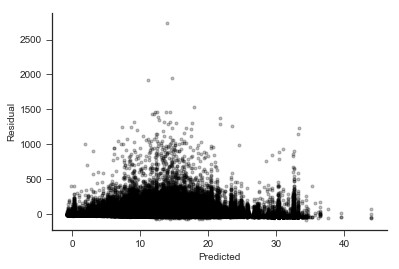

In [45]:
fig, ax = plt.subplots()
ax.scatter(res.fittedvalues, res.resid, color='k', marker='.', alpha=.25)
ax.set(xlabel='Predicted', ylabel='Residual')
sns.despine()

Those residuals should look like white noise. Looks like our linear model isn't flexible enough to model the delays, but I think that's enough for now.